In [1]:
import numpy as np
from coverage import *
from datetime import datetime, timezone, timedelta
import dataclasses
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import branca
import folium

! mkdir tmp

mkdir: tmp: File exists


In [2]:
from landsat import Instrument, Platform, Scene

In [3]:
start_dt = datetime.fromisoformat(Scene.start_utc)
num_days = 8

tles = gen_sats(
    # sat_nos=[Platform.norad_id] # How to best handle multiple platforms? (TLE vs. SPG4 model too)
    sat_nos=[39084]
    # sat_nos=[39084,49260]
)

inst = camera_model(
    name=Instrument.name, 
    fl=Instrument.focal_length_mm, 
    pitch=Instrument.pitch_um*1e-3, 
    h_pix=Instrument.rows, 
    v_pix=Instrument.cols, 
)

times = gen_times(
    start_yr=start_dt.year,
    start_mo=start_dt.month, 
    start_day=start_dt.day, 
    days=num_days, 
    step_min=Instrument.img_period)

xcell_size = ycell_size = .1

Satellite(s) Loaded from TLE:

[<EarthSatellite LANDSAT 8 catalog #39084 epoch 2022-06-15 18:38:09 UTC>]

Propogation time: 
 2022-07-19 00:00:00+00:00 
to 
 2022-07-26 23:59:56+00:00

In [4]:
## Batch FOV generation over N satellites - TODO: build multiple sats into config/ main script
gdfs = []
for tle in tles:
    sat = tle[0]
    fov_df = forecast_fovs(sat, times, inst)
    gdfs.append(fov_df)
fov_df = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="epsg:4326")

## Filter shapes crossing anti-meridian - also in main function
## TODO: Switch to stactools solution for this
fov_df["lonspan"] = fov_df.bounds['maxx'] - fov_df.bounds['minx']
fov_df = fov_df[fov_df["lonspan"] < 20].copy()

## Create cmap for unique satellites and create color column
sat_ids = list(fov_df["id"].unique()).sort()
cmap = branca.colormap.StepColormap(['red', 'blue'], sat_ids, vmin=139084, vmax = 149260)
fov_df['color'] = fov_df['id'].apply(cmap)

## Save to geojson based on sat name
for satname in fov_df.satellite.unique():
    fov_df[fov_df.satellite==satname].to_file("./tmp/{}_fovs.geojson".format(satname.replace(" ", "_")))
fov_df

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


geometry  satellite      id  \
117    POLYGON ((-128.72927 81.00731, -128.96516 82.6...  LANDSAT 8  139084   
118    POLYGON ((-137.24061 80.88269, -139.26020 82.4...  LANDSAT 8  139084   
119    POLYGON ((-145.36316 80.57145, -148.87690 82.1...  LANDSAT 8  139084   
120    POLYGON ((-152.84568 80.09115, -157.43611 81.5...  LANDSAT 8  139084   
121    POLYGON ((-159.55502 79.46485, -164.80931 80.8...  LANDSAT 8  139084   
...                                                  ...        ...     ...   
31414  POLYGON ((178.24783 69.12816, 174.03970 69.826...  LANDSAT 8  139084   
31415  POLYGON ((176.60982 67.92276, 172.58783 68.587...  LANDSAT 8  139084   
31416  POLYGON ((175.12586 66.70387, 171.27734 67.339...  LANDSAT 8  139084   
31417  POLYGON ((173.77430 65.47344, 170.08692 66.082...  LANDSAT 8  139084   
31418  POLYGON ((172.53712 64.23309, 168.99918 64.818...  LANDSAT 8  139084   

                          time    lonspan      color  
117    2022-07-19 00:42:54 UTC  13.154662  #ff0000ff  
118    2022-07-19 00:43:16 UTC  14.006797  #ff0000ff  
119    2022-07-19 00:43:38 UTC  14.133368  #ff0000ff  
120    2022-07-19 00:44:00 UTC  13.714094  #ff0000ff  
121    2022-07-19 00:44:22 UTC  12.965854  #ff0000ff  
...                        ...        ...        ...  
31414  2022-07-26 23:58:28 UTC   6.014541  #ff0000ff  
31415  2022-07-26 23:58:50 UTC   5.653205  #ff0000ff  
31416  2022-07-26 23:59:12 UTC   5.330799  #ff0000ff  
31417  2022-07-26 23:59:34 UTC   5.042177  #ff0000ff  
31418  2022-07-26 23:59:56 UTC   4.782926  #ff0000ff  

[15468 rows x 6 columns]

In [5]:
# fov_df.explore?

In [6]:
## Plotting FOVs

## Select AOI from gpd naturalearth dataset (filter by .name for country, .continent for continent)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != "Antarctica"]
# world = world[world.continent != "Seven seas (open ocean)"]

## Drop any FOVs not over land area
join = fov_df.sjoin(world, how="left").dropna()
fov_df.loc[join.index, 'mode'] = "SCIENCE"
fov_df.loc[~fov_df.index.isin(join.index), 'mode'] = "STANDBY"

## Make a folium map
m = fov_df[fov_df['mode']=="SCIENCE"].explore(color="color", style_kwds={'fillOpacity':0.2}, tooltip=["satellite", "time"])

## Add WRS2
# wrs2 = gpd.read_file('./WRS2_descending_0/WRS2_descending.shp')
# wrs2 = wrs2.cx[xmin: xmax, ymin: ymax]
# folium.GeoJson(data=wrs2["geometry"], overlay=False).add_to(m)

## View or save
m#.save("./tmp/fovs_map.html")

In [7]:
## Coverage data analysis for single satellite/ batch of satellites

## Set AOI
# aoi =  world[world.name == "Brazil"].geometry
# aoi =  world[world.continent == "North America"].geometry

## Or read in aoi from .geojson
# aoi = world[world.name == "United States of America"].geometry # Includes Alaska...
aoi = gpd.read_file('./aois/eastern_us.geojson').geometry # ...so use AOI for subsection of US

## Filter fov_df by aoi
xmin, ymin, xmax, ymax= aoi.total_bounds
# fov_df = fov_df.cx[xmin: xmax, ymin: ymax]
# grid, grid_shape = calculate_revisits(fov_df, aoi, grid_x=xcell_size, grid_y=ycell_size)
# grid.to_file('./tmp/all_revisits.geojson')
# grid.n_visits.fillna(0).describe()

In [8]:
# m = revisit_map(grid, grid_shape, grid_x=xcell_size, grid_y=ycell_size)
# m#.save("./tmp/revisits_map.html")

In [9]:
fov_df.time = pd.to_datetime(fov_df.time)

In [10]:
fov_df.set_index('time')

geometry  \
time                                                                           
2022-07-19 00:42:54+00:00  POLYGON ((-128.72927 81.00731, -128.96516 82.6...   
2022-07-19 00:43:16+00:00  POLYGON ((-137.24061 80.88269, -139.26020 82.4...   
2022-07-19 00:43:38+00:00  POLYGON ((-145.36316 80.57145, -148.87690 82.1...   
2022-07-19 00:44:00+00:00  POLYGON ((-152.84568 80.09115, -157.43611 81.5...   
2022-07-19 00:44:22+00:00  POLYGON ((-159.55502 79.46485, -164.80931 80.8...   
...                                                                      ...   
2022-07-26 23:58:28+00:00  POLYGON ((178.24783 69.12816, 174.03970 69.826...   
2022-07-26 23:58:50+00:00  POLYGON ((176.60982 67.92276, 172.58783 68.587...   
2022-07-26 23:59:12+00:00  POLYGON ((175.12586 66.70387, 171.27734 67.339...   
2022-07-26 23:59:34+00:00  POLYGON ((173.77430 65.47344, 170.08692 66.082...   
2022-07-26 23:59:56+00:00  POLYGON ((172.53712 64.23309, 168.99918 64.818...   

                           satellite      id    lonspan      color     mode  
time                                                                         
2022-07-19 00:42:54+00:00  LANDSAT 8  139084  13.154662  #ff0000ff  STANDBY  
2022-07-19 00:43:16+00:00  LANDSAT 8  139084  14.006797  #ff0000ff  STANDBY  
2022-07-19 00:43:38+00:00  LANDSAT 8  139084  14.133368  #ff0000ff  STANDBY  
2022-07-19 00:44:00+00:00  LANDSAT 8  139084  13.714094  #ff0000ff  STANDBY  
2022-07-19 00:44:22+00:00  LANDSAT 8  139084  12.965854  #ff0000ff  STANDBY  
...                              ...     ...        ...        ...      ...  
2022-07-26 23:58:28+00:00  LANDSAT 8  139084   6.014541  #ff0000ff  SCIENCE  
2022-07-26 23:58:50+00:00  LANDSAT 8  139084   5.653205  #ff0000ff  SCIENCE  
2022-07-26 23:59:12+00:00  LANDSAT 8  139084   5.330799  #ff0000ff  SCIENCE  
2022-07-26 23:59:34+00:00  LANDSAT 8  139084   5.042177  #ff0000ff  SCIENCE  
2022-07-26 23:59:56+00:00  LANDSAT 8  139084   4.782926  #ff0000ff  SCIENCE  

[15468 rows x 6 columns]

In [11]:
# fov_df.groupby('name').count()

In [12]:
# fov_df = fov_df[1:1000]
# fov_df = fov_df.reset_index().drop_duplicates('index')
# fov_df = fov_df.filter(fov_df["time_gap"] < 0.008 )

In [13]:
# fov_df

In [14]:
import matplotlib.pyplot as plt

In [15]:
fov_df["frac_days"] = fov_df.time.dt.dayofweek + fov_df.time.dt.hour/24 + fov_df.time.dt.minute/(24*60) + fov_df.time.dt.second/(24*60*60)
fov_df['time_gap'] = fov_df['frac_days'] - fov_df['frac_days'].shift(1)

In [16]:
fov_df.frac_days.describe()

count    15468.000000
mean         3.241453
std          2.004003
min          0.003912
25%          1.477390
50%          2.985220
75%          4.976615
max          6.969282
Name: frac_days, dtype: float64

In [17]:
# fov_df.reset_index().drop_duplicates('index').drop('time', axis=1).explore()

/Users/kevinlalli/miniconda3/envs/coverage/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<BarContainer object of 658 artists>

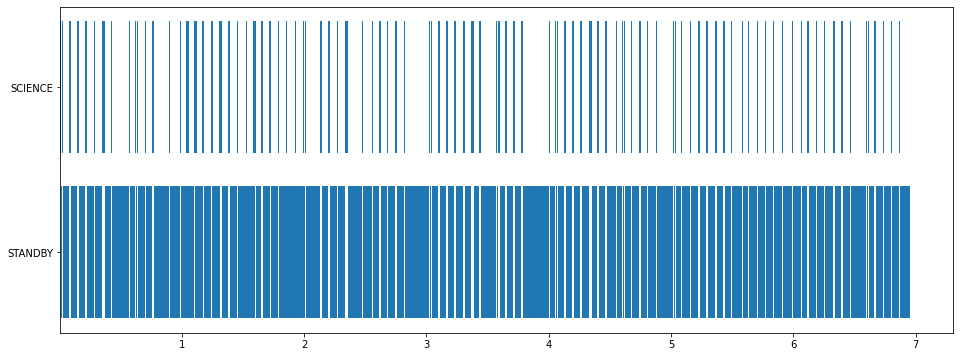

In [18]:
my_column_changes = fov_df["mode"].shift() != fov_df["mode"]

change = fov_df[my_column_changes]#[:100]

change['time_gap'] = change['frac_days'].shift(-1) - change['frac_days']
change = change[change['time_gap'] > 0]

fig, ax = plt.subplots(1, figsize=(16,6))
ax.barh(change['mode'], change.time_gap, left=change.frac_days) #, color=df.color)

<AxesSubplot:ylabel='Frequency'>

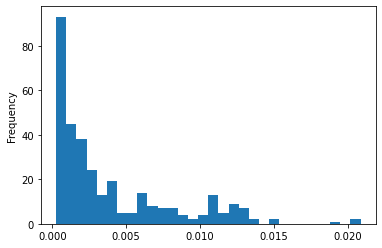

In [19]:
change[change["mode"] == "SCIENCE"].time_gap.plot.hist(bins=30)

In [20]:
change[change["mode"] == "SCIENCE"].time_gap.sum()/(change[change["mode"] == "STANDBY"].time_gap.sum() + change[change["mode"] == "SCIENCE"].time_gap.sum())

0.16177369047236304